In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# 유니코드에서  음수 부호설정
plt.rc('axes', unicode_minus=False)

# ===============================================
### hs_to_bec (기준도표)

In [2]:
hs12=pd.read_excel(r'Hs2012.xlsx',usecols='d,f,g', dtype={'HS6' : object, 'BEC5Code1' : object, 'BEC5Code2' : object})
hs17=pd.read_excel(r'Hs2017.xlsx',usecols='d, f, g', dtype={'HS6' : object, 'BEC5Code1' : object, 'BEC5Code2' : object})
df=pd.merge(hs12, hs17, how='outer', on='HS6')

## 변동이 없는 경우
both = df[ df['HS6'].isin(hs12['HS6']) & df['HS6'].isin(hs17['HS6'])]
both = both[ both['BEC5Code1_x'] == both['BEC5Code1_y']]
both.columns = ['HS6', 'c1', 'c2', 'c1_y', 'c2_y']
both = both.iloc[:, :3]

# 2012년도(변환 전) HS코드 변수명 old
old = df[df['HS6'].isin(hs17['HS6']) == False].iloc[:,:3]
old.columns = ['HS6', 'c1', 'c2']

# 2017년도(변환 후) HS코드 변수명 new
new = df[df['HS6'].isin(hs12['HS6']) == False].iloc[:, [0,3,4]]
new.columns = ['HS6', 'c1', 'c2']

hs_to_bec = pd.concat([both, old, new]) ## 중복없음 확인 완료
hs_to_bec.head(5)

## 카테고리별 HS6코드 분류
def category (i) :
    global hs_to_bec
    globals()['cd{}'.format(i)] = hs_to_bec[hs_to_bec['c1'].str.startswith(f'{i}') | hs_to_bec['c2'].str.startswith(f'{i}')]

for i in range (1,9) :
    category(i)

gr1 = cd1['HS6'].to_list()
gr2 = cd2['HS6'].to_list()
gr3 = cd3['HS6'].to_list()
gr4 = cd4['HS6'].to_list()
gr5 = cd5['HS6'].to_list()
gr6 = cd6['HS6'].to_list()
gr7 = cd7['HS6'].to_list() 
gr8 = cd8['HS6'].to_list()

cd1.head()  ##cd1-cd8까지 전부 같은 구조임

,HS6,c1,c2
1,010129,1111,NaN
2,010130,1111,NaN
3,010190,1111,NaN
4,010221,112010,NaN
5,010229,1111,NaN


## 대세계 수출입 전체 데이터 읽고 병합

In [3]:
os.chdir('./total_world/')
files = os.listdir()
df_dict = {}
for i in files:
    df_dict[i.split('.')[0]] = pd.read_csv(i, sep='\t')

for k in df_dict :
    df_dict[k]['Country'] = k[3:]
    if k[0:2] == 'ex' :
        df_dict[k]['Trade'] = 'Export'
    else :
        df_dict[k]['Trade'] = 'Import'
    
    df_dict[k].columns = ['Code', 'Product label', '2012', '2013', '2014', 
                         '2015', '2016', '2017', '2018', '2019', '2020', '2021', 'Unnamed: 12', 'Country', 'Trade']

t_list = []
for titles in df_dict :
    t_list.append(df_dict[titles])
df = pd.concat(t_list)

df = df.dropna(how='all', axis=1)
df = df.replace(0, np.nan)
df = df.dropna(thresh=11)

In [4]:
df1 = df[df['Code'] != 'TOTAL']

### ========================================================================
# Step 1 - 국가별 총 무역액 기준 추이

In [5]:
## 총 무역액 기준 추이
df_total = df[df['Code']=='TOTAL']
df_total = df_total.groupby('Country').sum()

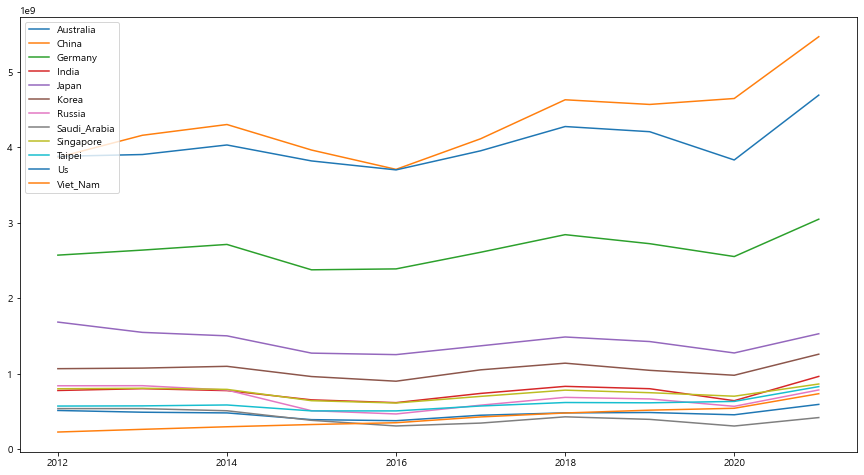

In [6]:
df_total.T.plot(figsize=(15,8))
plt.legend(loc='upper left')

# ===============================================
# Step 2 - 카테고리, 가공단계별 분류 추가

## 2-1. 대분류 :  카테고리별 분류 추가

In [7]:
gr = [gr1, gr2, gr3, gr4, gr5, gr6, gr7, gr8]
for i in range(1,9):
    globals()['cate_{}'.format(i)] = df1[df1['Code'].isin(gr[i-1])]
    globals()['cate_{}'.format(i)]['Category'] = f'Category{i}'

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4528\2787850334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()['cate_{}'.format(i)]['Category'] = f'Category{i}'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4528\2787850334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()['cate_{}'.format(i)]['Category'] = f'Category{i}'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4528\2787850334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [8]:
df2 = pd.concat([cate_1, cate_2, cate_3, cate_4, cate_5, cate_6, cate_7, cate_8])

## 2-2. 소분류  :  카테고리 내 -  가공단계별 분류 추가

In [9]:
itm = [f'{i}11' for i in range(1,9)]
fxd = [f'{i}12' for i in range(1,9)]
fin = [f'{i}13' for i in range(1,9)]

stage = []
for i in hs_to_bec['c1'].to_list() :
    if i[:3] in itm :
        stage.append('1Intermediate Consumption')
    elif i[:3] in fxd :
        stage.append('2Gross Fixed Capital')
    else : 
        stage.append('3Final Consumption')
hs_to_bec['Stage'] = stage

cd_list = []
proc_stage =[]
for cts in df2['Code'] :
    cd_list.extend(hs_to_bec[hs_to_bec['HS6'] == cts].c1.to_list())
    proc_stage.extend(hs_to_bec[hs_to_bec['HS6'] == cts].Stage.to_list())
df2['BEC'] = cd_list
df2['Process'] = proc_stage

In [10]:
df2.head()
os.chdir('../')
df2.to_csv('df2.csv')

In [11]:
df2

,Code,Product label,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,Country,Trade,Category,BEC,Process
7,100199,"Wheat and meslin (excluding seed for sowing, a...",6711806.0,5832548.0,5270968.0,4352815.0,3557764.0,4560185.0,3028659.0,2513816.0,2710166.0,7097704.0,Australia,Export,Category1,1111,1Intermediate Consumption
10,020230,"Frozen, boneless meat of bovine animals",2828207.0,3370846.0,4371609.0,4277980.0,3075554.0,3223065.0,3694760.0,4468083.0,3749032.0,3750481.0,Australia,Export,Category1,113101,3Final Consumption
13,020130,"Fresh or chilled bovine meat, boneless",1921467.0,1891428.0,2273194.0,2451140.0,2201799.0,2223558.0,2492495.0,2630413.0,2669019.0,2892798.0,Australia,Export,Category1,113101,3Final Consumption
16,120510,"Low erucic acid rape or colza seeds """"yielding...",1527093.0,2196830.0,1285502.0,1131116.0,886146.0,1277786.0,927314.0,669779.0,786927.0,2157781.0,Australia,Export,Category1,1111,1Intermediate Consumption
17,100390,Barley (excluding seed for sowing),1358431.0,1484784.0,1597948.0,1306758.0,1124787.0,1620624.0,1371855.0,726624.0,913124.0,1983793.0,Australia,Export,Category1,1111,1Intermediate Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3967,401036,"Endless synchronous belts, of vulcanised rubbe...",330.0,237.0,269.0,326.0,339.0,502.0,284.0,252.0,337.0,557.0,Viet_Nam,Import,Category8,811210,1Intermediate Consumption
3968,901540,Photogrammetrical surveying instruments and ap...,74.0,164.0,305.0,370.0,330.0,576.0,1045.0,208.0,607.0,556.0,Viet_Nam,Import,Category8,812020,2Gross Fixed Capital
4044,360500,Matches (excluding pyrotechnic articles of hea...,1.0,5.0,3.0,15.0,8.0,10.0,27.0,46.0,403.0,475.0,Viet_Nam,Import,Category8,813101,3Final Consumption
4137,401033,Endless transmission belts of trapezoidal cros...,3153.0,572.0,284.0,507.0,455.0,379.0,456.0,549.0,566.0,377.0,Viet_Nam,Import,Category8,811210,1Intermediate Consumption


# ===============================================
# Step 3 - 분석 및 시각화 : 분야/가공단계별 수출입액
> * 분야·가공단계별 교역국의 수출입액 비중 
> * 국가별 분류 -> 분야별 수출입액 -> max 주요품목
> * 국가별 분류 -> 가공단계별 수출입액 -> max 주요품목

## 한국의 수출입액 비중 추이 (혹시나 그냥 해봄)

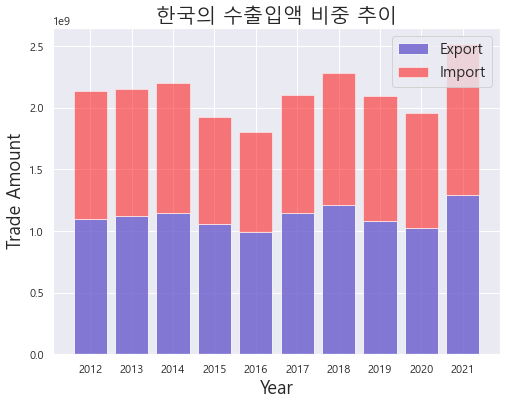

In [12]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.set(style='darkgrid')
plt.rcParams['font.family'] = 'Malgun Gothic'

x=df_dict['ex_Korea'].columns[2:-3]
y=df_dict['ex_Korea'].sum()[2:-3]
p1 = plt.bar(x,y, color='slateblue', alpha=0.8)

a=df_dict['im_Korea'].columns[2:-3]
b=df_dict['im_Korea'].sum()[2:-3]
plt.title('한국의 수출입액 비중 추이', fontsize=20, pad=5)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Trade Amount', fontsize=18)
p2 = plt.bar(a,b, bottom=y, color='red', alpha=0.5);
plt.legend((p1[0], p2[0]), ('Export', 'Import'), fontsize=15)

## 3.1. 카테고리(1유형-8유형)기준  : 교역국 간 총 무역액 비중

In [13]:
## 분야별 - 국가별 수출입액 비중
df_cat = df2.groupby(['Category', 'Country']).sum()
df_cat.head(12)

2012         2013         2014         2015  \
Category  Country                                                            
Category1 Australia      50852906.0   52504834.0   54716147.0   51413440.0   
          China         197280358.0  210516378.0  226332034.0  221587967.0   
          Germany       211450489.0  224246439.0  226561758.0  194593449.0   
          India          63154747.0   71808542.0   71793982.0   67040507.0   
          Japan          97664872.0   89276589.0   86095045.0   79021892.0   
          Korea          41526828.0   41356177.0   43256654.0   41473510.0   
          Russia         75144298.0   75403658.0   75047721.0   55132324.0   
          Saudi_Arabia   27999734.0   30335669.0   30831669.0   29701941.0   
          Singapore      24578218.0   25456920.0   26604335.0   24845574.0   
          Taipei         16116383.0   16530189.0   20353723.0   19373207.0   
          Us            317279962.0  324134445.0  342596535.0  324731281.0   
          Viet_Nam       38585650.0   39846210.0   44427799.0   45037379.0   

                               2016         2017         2018         2019  \
Category  Country                                                            
Category1 Australia      48180917.0   52963251.0   51923466.0   51494749.0   
          China         211624381.0  226425136.0  239440481.0  252243398.0   
          Germany       197725798.0  211322099.0  220428973.0  213647515.0   
          India          63286010.0   71010445.0   66957462.0   66872709.0   
          Japan          79636469.0   82870906.0   87421709.0   88133546.0   
          Korea          41028347.0   42914858.0   45971390.0   48107834.0   
          Russia         57514208.0   67014638.0   68524516.0   67951942.0   
          Saudi_Arabia   25542811.0   25629167.0   26141507.0   25939814.0   
          Singapore      24046196.0   24262725.0   28551499.0   28929245.0   
          Taipei         19115927.0   20423196.0   21228064.0   21174382.0   
          Us            323358309.0  335176396.0  348288494.0  346994004.0   
          Viet_Nam       46758067.0   52773509.0   53707952.0   53169191.0   

                               2020         2021  
Category  Country                                 
Category1 Australia      50132214.0   63839196.0  
          China         270719603.0  307015893.0  
          Germany       217845571.0  238240263.0  
          India          68444864.0   89917179.0  
          Japan          84010284.0   92987654.0  
          Korea          47667126.0   54620351.0  
          Russia         69969977.0   85041169.0  
          Saudi_Arabia   26425869.0   29096257.0  
          Singapore      28379022.0   32578351.0  
          Taipei         20736410.0   23723945.0  
          Us            354251379.0  424994078.0  
          Viet_Nam       53372284.0   58761339.0

### 버전 1 - 선 차트

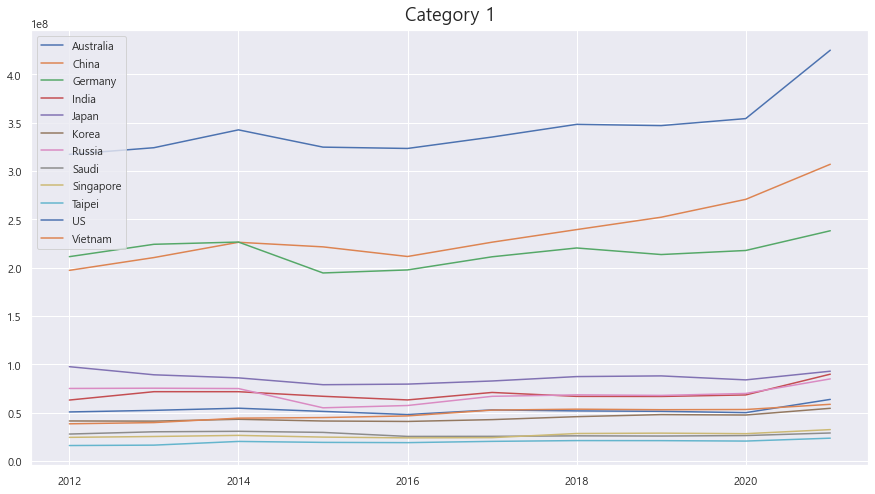

In [14]:
for i in range(8):
    df_cat.transpose().iloc[:,12*i:12+12*i].plot(figsize=(15,8))
    plt.title(f'Category {i+1}', fontsize=18, pad=10)
    plt.legend(['Australia', 'China', 'Germany', 'India', 'Japan', 'Korea',
                'Russia', 'Saudi', 'Singapore', 'Taipei','US', 'Vietnam'], loc='upper left')
    break


### 버전 2 - 누적 바 차트

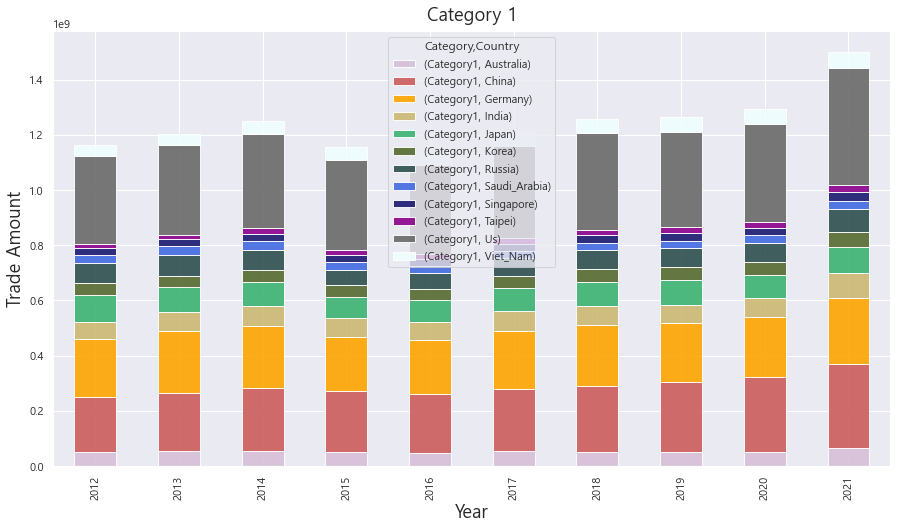

In [15]:
colors=['thistle', 'indianred', 'orange', 'y', 'mediumseagreen', 'darkolivegreen','darkslategrey', 'royalblue', 'midnightblue', 'darkmagenta', 'dimgrey', 'azure']
tit = ['1-Intermediate Consumption', '2-Gross Fixed Capital', '3-Final Consumption']

for i in range(8):
    df_cat.transpose().iloc[:,12*i:12+12*i].plot(kind='bar', color=colors, alpha=0.9, figsize=(15,8), stacked=True)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Trade Amount', fontsize=18)
    plt.title(f'Category {i+1}', fontsize=18, pad=10);
    break

### 버전 3 - 도넛 차트

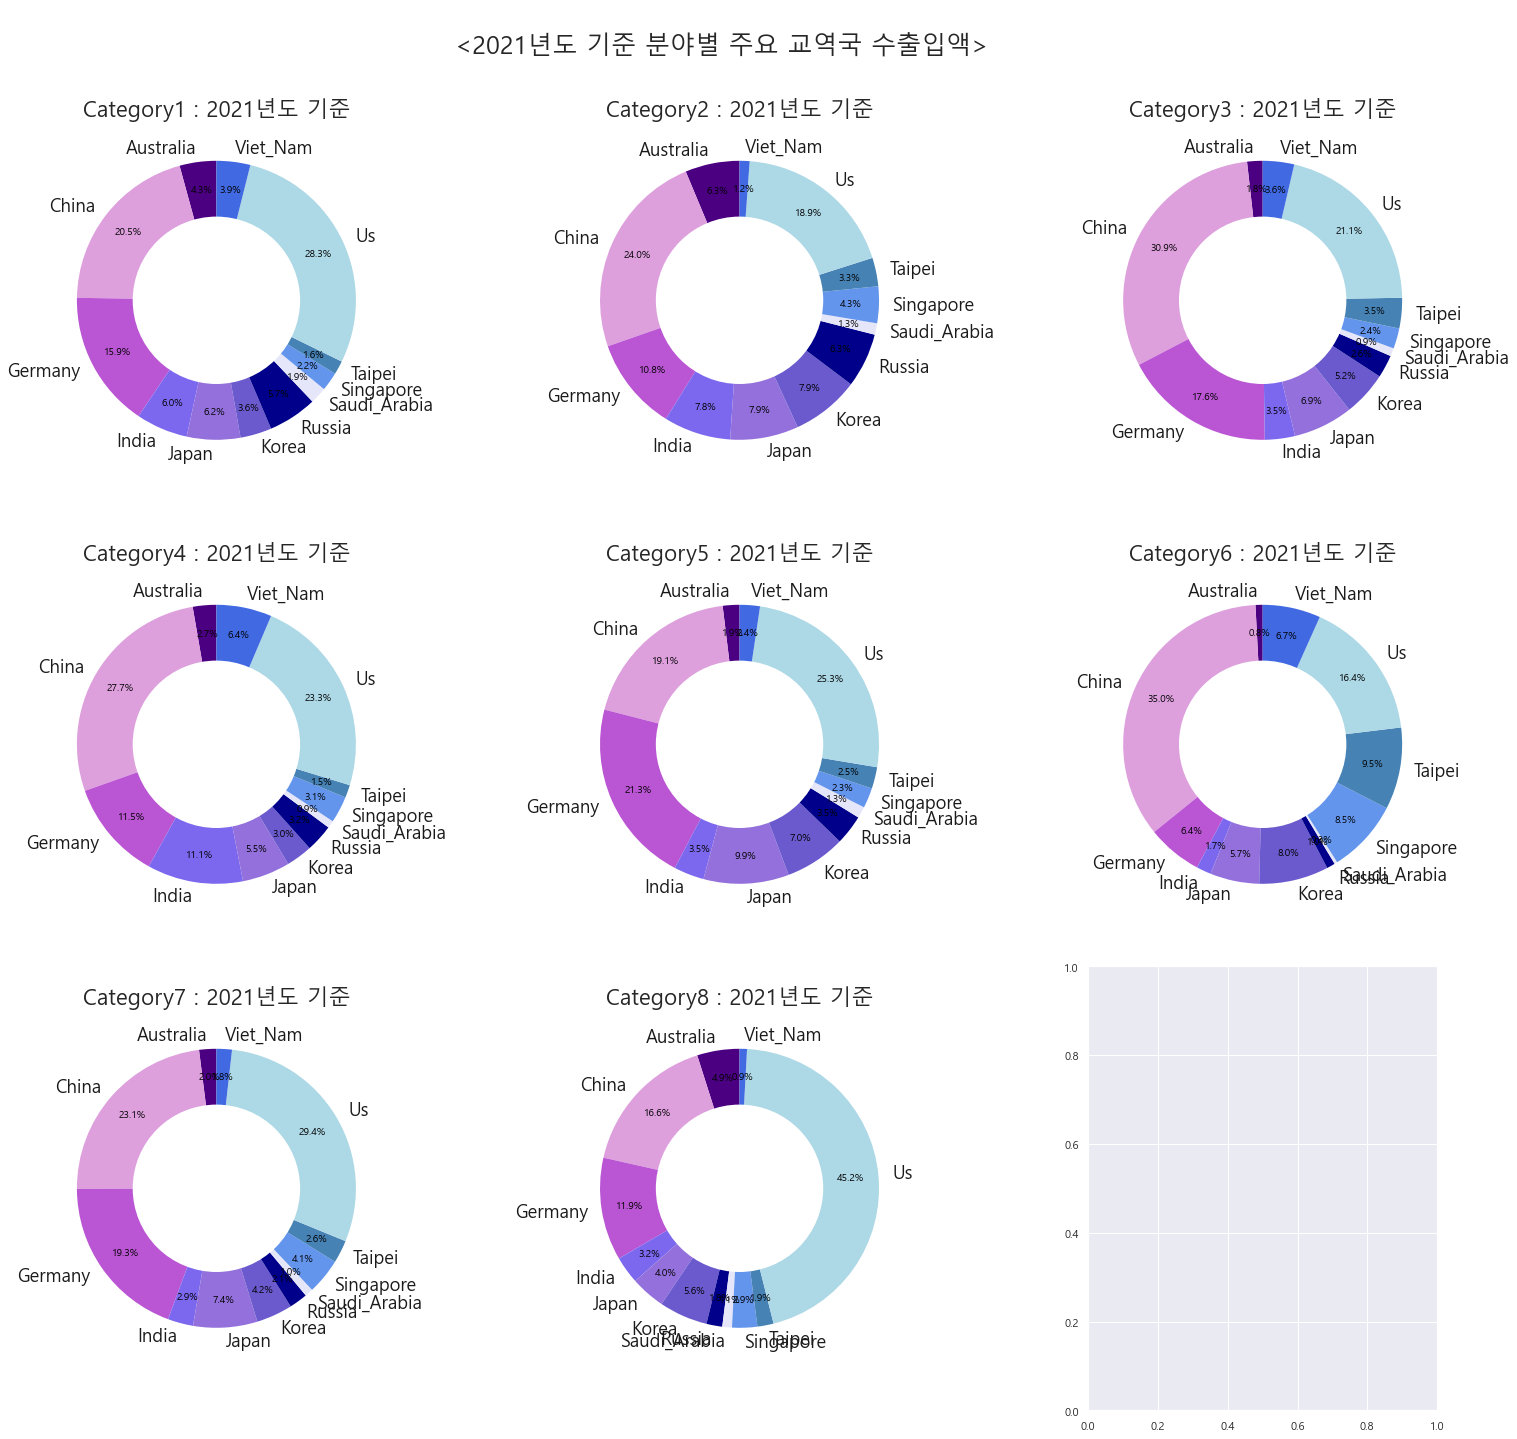

In [16]:
color = ['indigo', 'plum' , 'mediumorchid' ,'mediumslateblue', 'mediumpurple', 'slateblue', 
         'darkblue', 'lavender', 'cornflowerblue', 'steelblue', 'lightblue', 'royalblue']
label = df2['Country'].unique()
titles = [f'Category{i} : 2021년도 기준' for i in range(1,9)]

data =[]
## 2021년도 분야별 수출입액
for i in range(8):
    data.append(df_cat.iloc[12*i:12+12*i ,9])

    
fig, axes = plt.subplots(3,3,figsize=(25, 25))
plt.subplots_adjust(bottom=0.2, top=0.94, wspace=0.5, hspace=0) 
plt.suptitle('\n <2021년도 기준 분야별 주요 교역국 수출입액>', fontsize=25)

for i in range(3):
    for v in range(3) :
        if 3*i+v == 8 :
            break
        else :
            ax = axes[i][v]
            wedges, texts, autotexts = ax.pie(data[(3*i)+v], labels=label,
                                         colors=color,  autopct='%1.1f%%', pctdistance=0.80,
                                          shadow=False, startangle=90)

            for w in wedges: # 조각 설정
                w.set_linewidth(0)
                w.set_edgecolor('w')

            for t in texts: # label 설정
                t.set_color('k')
                t.set_fontsize(18)

            for a in autotexts: # 퍼센티지 설정
                a.set_color('black')
                a.set_fontsize(10)
            '''
            아래의 2줄은 파이차트를 도넛차트로 보이게끔 하는 trick임
            '''
            centre_circle = plt.Circle((0,0), 0.60, color='black', fc='white', linewidth=0)
            ax.add_artist(centre_circle)

            ax.set_title(titles[(3*i)+v], fontdict={'fontsize': 22}, pad=10)

## 3.2. 가공단계(중간재-자본재-최종재) 기준 : 교역국의 수출입액 비중

In [17]:
df_prc2 = df2.groupby(['Process', 'Trade', 'Country']).sum()
df_prc2

2012         2013  \
Process                   Trade  Country                                  
1Intermediate Consumption Export Australia     201246351.0  196589051.0   
                                 China         810922509.0  892286912.0   
                                 Germany       669050180.0  688701414.0   
                                 India         136355394.0  162604899.0   
                                 Japan         428195203.0  385612002.0   
...                                                    ...          ...   
3Final Consumption        Import Saudi_Arabia   49681069.0   54311632.0   
                                 Singapore     123628771.0  122331706.0   
                                 Taipei         46395938.0   49729871.0   
                                 Us            731938827.0  757206748.0   
                                 Viet_Nam       18706563.0   18665115.0   

                                                      2014         2015  \
Process                   Trade  Country                                  
1Intermediate Consumption Export Australia     190021965.0  136177814.0   
                                 China         931051332.0  927310654.0   
                                 Germany       707499961.0  606458785.0   
                                 India         147539579.0  132994228.0   
                                 Japan         367348564.0  324498009.0   
...                                                    ...          ...   
3Final Consumption        Import Saudi_Arabia   56454181.0   59891911.0   
                                 Singapore     119386212.0   84613210.0   
                                 Taipei         51697748.0   42630792.0   
                                 Us            775314840.0  776362786.0   
                                 Viet_Nam       21115274.0   20904747.0   

                                                      2016         2017  \
Process                   Trade  Country                                  
1Intermediate Consumption Export Australia     134168626.0  164179350.0   
                                 China         862057532.0  923590528.0   
                                 Germany       609123622.0  675845705.0   
                                 India         132144145.0  151014328.0   
                                 Japan         331011181.0  359127153.0   
...                                                    ...          ...   
3Final Consumption        Import Saudi_Arabia   48495711.0   47067262.0   
                                 Singapore      74351293.0   90445511.0   
                                 Taipei         40816681.0   44605022.0   
                                 Us            756706023.0  787676595.0   
                                 Viet_Nam       22203094.0   28179682.0   

                                                       2018          2019  \
Process                   Trade  Country                                    
1Intermediate Consumption Export Australia     1.754724e+08  1.883092e+08   
                                 China         1.043111e+09  1.049302e+09   
                                 Germany       7.370133e+08  6.969814e+08   
                                 India         1.641274e+08  1.614257e+08   
                                 Japan         3.754104e+08  3.543769e+08   
...                                                     ...           ...   
3Final Consumption        Import Saudi_Arabia  4.695703e+07  5.255429e+07   
                                 Singapore     1.015500e+08  9.292512e+07   
                                 Taipei        4.966619e+07  4.606546e+07   
                                 Us            8.295939e+08  8.249455e+08   
                                 Viet_Nam      3.018312e+07  3.160393e+07   

                                                       2020          2021  
Process                   Trade  Country        

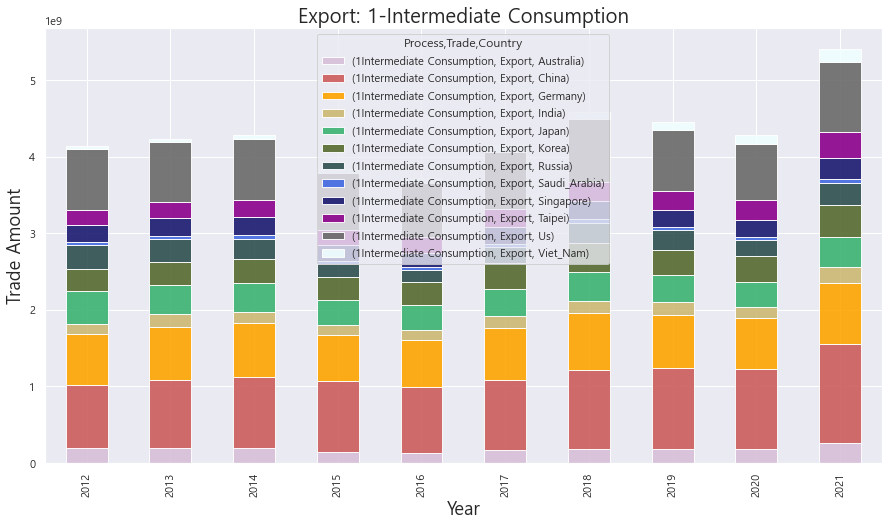

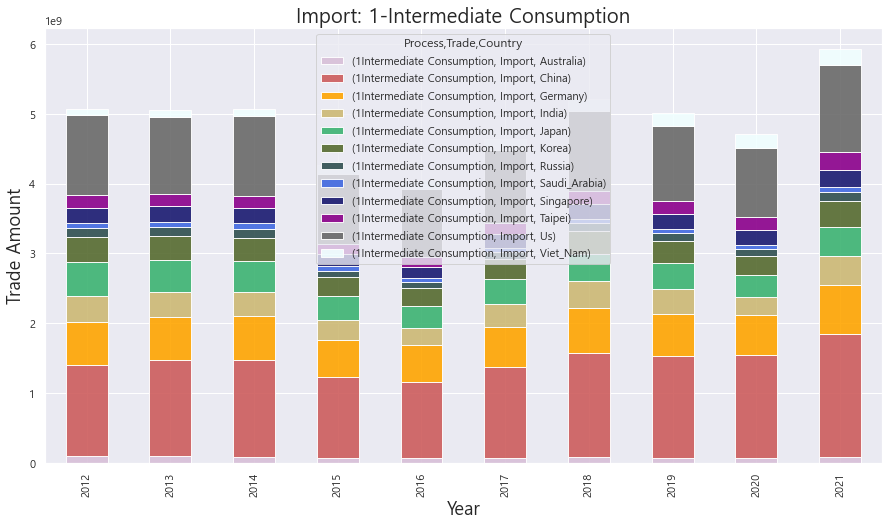

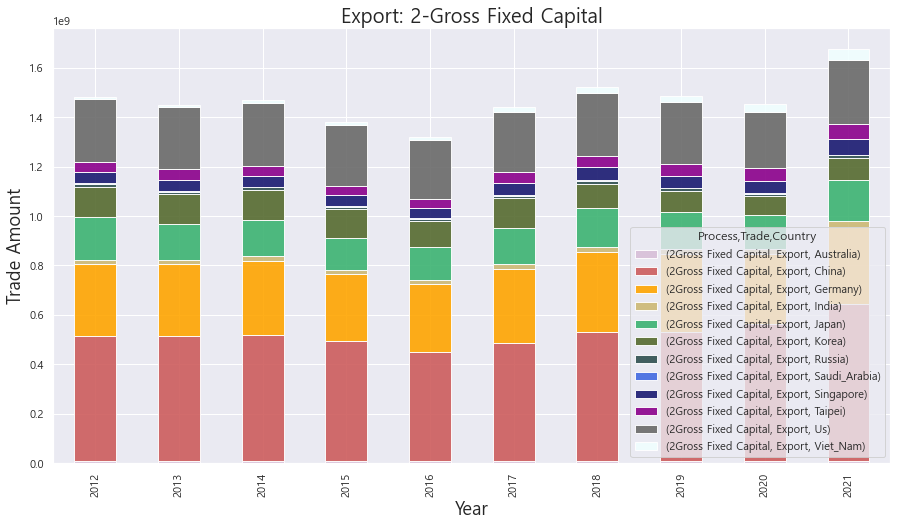

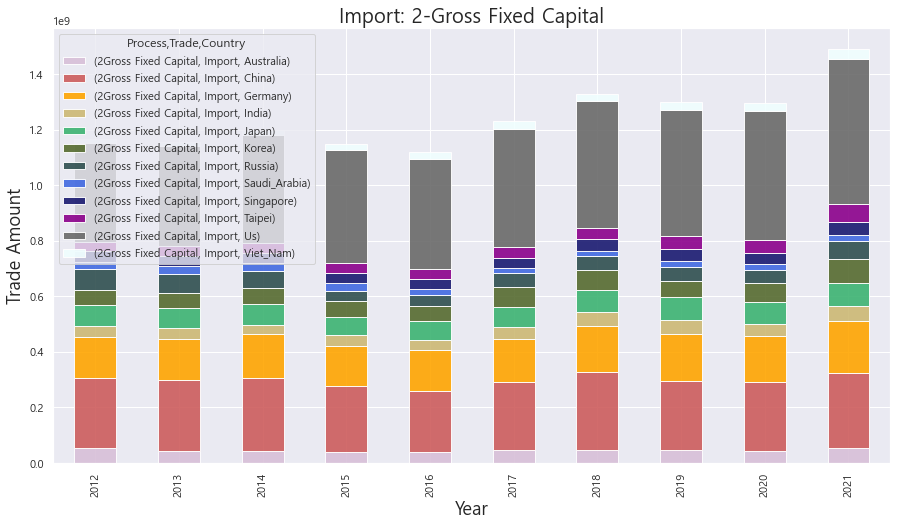

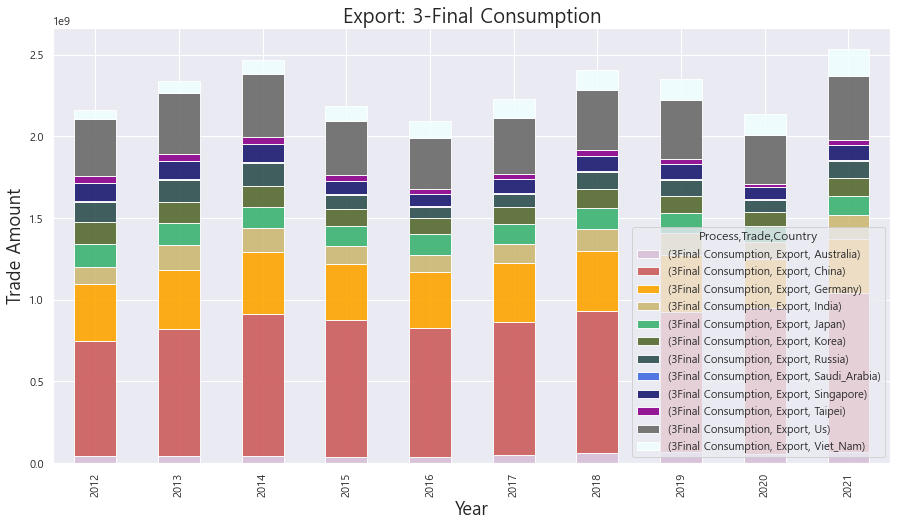

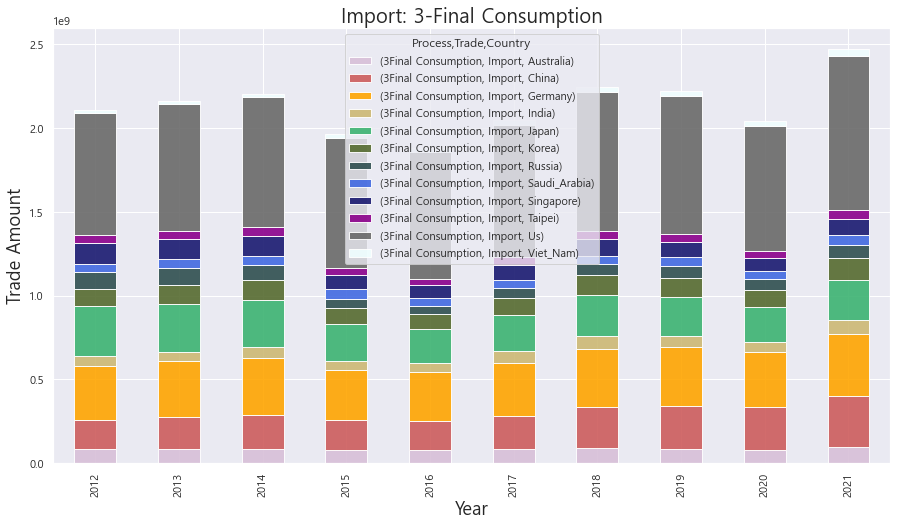

In [18]:
colors=['thistle', 'indianred', 'orange', 'y', 'mediumseagreen', 'darkolivegreen','darkslategrey', 'royalblue', 'midnightblue', 'darkmagenta', 'dimgrey', 'azure']
tit = ['1-Intermediate Consumption', '2-Gross Fixed Capital', '3-Final Consumption']

for i in range(6):
    df_prc2.transpose().iloc[:, 12*i:12+12*i].plot(kind='bar', color=colors, alpha=0.9, figsize=(15,8), stacked=True)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Trade Amount', fontsize=18)
    if (12+12*i)%24 == 0 :
        plt.title(f'Import: {tit[(i-1)//2]}', fontsize=20, pad=5)
    else :
        plt.title(f'Export: {tit[i//2]}', fontsize=20, pad=5)

## 3.3. (국가별-분야별) 각 주요국들의 카테고리별 수출입 구조

In [19]:
sns.set(style='darkgrid')

In [20]:
## 국가별 - 수출입 - 가공단계분류
df_nat = df2.groupby(['Country','Trade','Category']).sum()
df_nat.head(16)

2012         2013         2014  \
Country   Trade  Category                                           
Australia Export Category1   33275094.0   34071579.0   34739164.0   
                 Category2  155078749.0  154135347.0  153707428.0   
                 Category3   17278162.0   16156529.0   16192258.0   
                 Category4   23333162.0   20718024.0   17993457.0   
                 Category5    7960239.0    7652881.0    7687640.0   
                 Category6    3547466.0    3712147.0    3958241.0   
                 Category7    8291647.0    7162364.0    6528857.0   
                 Category8     263448.0     308917.0     294931.0   
          Import Category1   17577812.0   18433255.0   19976983.0   
                 Category2   59030933.0   53682764.0   51281332.0   
                 Category3   42320961.0   40815629.0   41206165.0   
                 Category4   18667323.0   17673677.0   17140411.0   
                 Category5   48430752.0   43326025.0   40111877.0   
                 Category6   26861414.0   24949905.0   24792581.0   
                 Category7   22918433.0   22255856.0   21751042.0   
                 Category8    1908643.0    1057326.0    1854621.0   

                                   2015         2016         2017  \
Country   Trade  Category                                           
Australia Export Category1   32997329.0   30161458.0   34718296.0   
                 Category2  102445385.0  101092592.0  132753834.0   
                 Category3   13408361.0   12156872.0   14350785.0   
                 Category4   15728764.0   19078733.0   19934448.0   
                 Category5    6684097.0    6118653.0    5809878.0   
                 Category6    3875738.0    3699191.0    3853819.0   
                 Category7    5567108.0    6323413.0    6646927.0   
                 Category8     313822.0     262455.0     264714.0   
          Import Category1   18416111.0   18019459.0   18244955.0   
                 Category2   35047136.0   28931337.0   35650885.0   
                 Category3   39726661.0   35110777.0   37427595.0   
                 Category4   16552255.0   18523256.0   17978443.0   
                 Category5   37453862.0   39130010.0   48938405.0   
                 Category6   23409992.0   21860454.0   24276489.0   
                 Category7   19948384.0   20090941.0   20527975.0   
                 Category8     951881.0    1001117.0    1156819.0   

                                   2018         2019         2020         2021  
Country   Trade  Category                                                       
Australia Export Category1   32972750.0   32321398.0   30907069.0   42112717.0  
                 Category2  155115300.0  172950257.0  161258997.0  229302077.0  
                 Category3   16031745.0   14554722.0   13102791.0   17915781.0  
                 Category4   20860554.0   21458439.0   21032611.0   23526519.0  
                 Category5    5987134.0    6040673.0    4931932.0    5533572.0  
                 Category6    3858781.0    4114007.0    3535887.0    4063640.0  
                 Category7    7406851.0    7759282.0    6994437.0    7439546.0  
                 Category8     312542.0     368627.0     322565.0     290955.0  
          Import Category1   18950716.0   19173351.0   19225145.0   21726479.0  
                 Category2   44231424.0   39715673.0   29378172.0   41252170.0  
                 Category3   41670914.0   38716201.0   39239574.0   47904665.0  
                 Category4   18559320.0   18442452.0   21441568.0   21543101.0  
                 Category5   43964049.0   40532481.0   35965237.0   47033629.0  
                 Category6   26717645.0   25000339.0   24654631.0   28657067.0  
                 Category7   21321633.0   21160974.0   21760582.0   25576911.0  
                 Category8    1138001.0    1176954.0    1040477.0    1541030.0

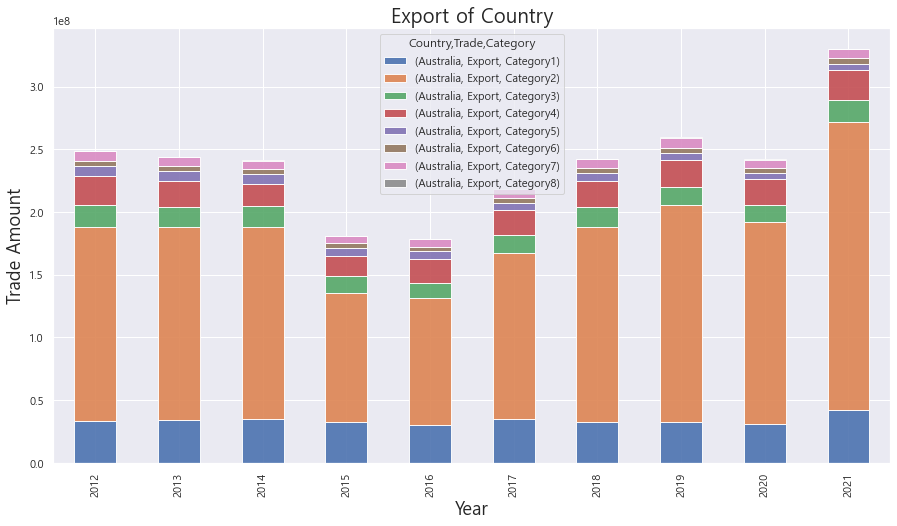

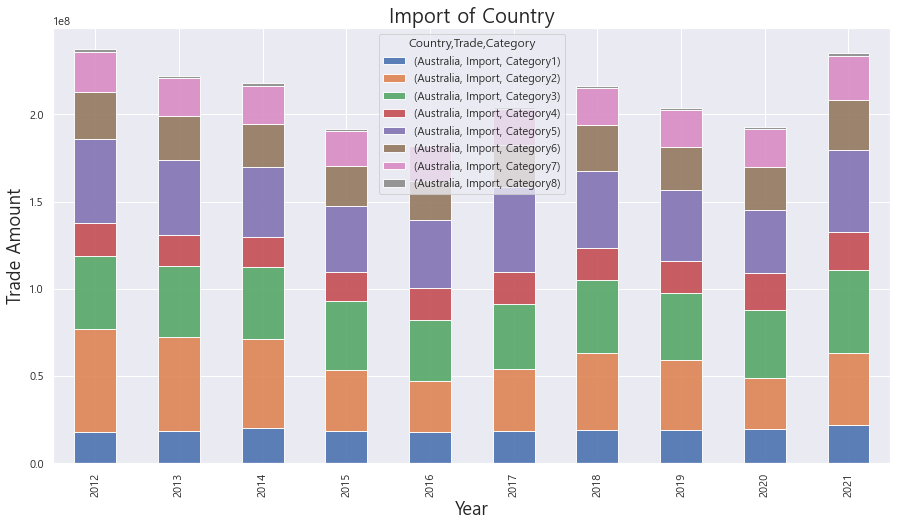

In [38]:
for i in range(24):
    df_nat.transpose().iloc[:, 8*i:8+8*i].plot(kind='bar', figsize=(15,8), alpha=0.9, stacked=True)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Trade Amount', fontsize=18)
    
    if (8+8*i)%16 == 0 :
        plt.title('Import of Country', fontsize=20, pad=5)
        break
    else :
        plt.title('Export of Country', fontsize=20, pad=5)

## 3.4. (국가별-가공단계별) 각 주요국들의 가공단계별 추이

In [22]:
df_prc = df2.groupby(['Country', 'Trade', 'Process']).sum()
df_prc.transpose()

Country                 Australia                                          \
Trade                      Export                                           
Process 1Intermediate Consumption 2Gross Fixed Capital 3Final Consumption   
2012                  201246351.0            7164363.0         40617253.0   
2013                  196589051.0            6631365.0         40697372.0   
2014                  190021965.0            7319937.0         43760074.0   
2015                  136177814.0            6486383.0         38356407.0   
2016                  134168626.0            6408563.0         38316178.0   
2017                  164179350.0            6626654.0         47526697.0   
2018                  175472442.0            7205468.0         59867747.0   
2019                  188309154.0            7320078.0         63938173.0   
2020                  182909510.0            6253461.0         52923318.0   
2021                  255613270.0            7247806.0         67323731.0   

Country                                                                    \
Trade                      Import                                           
Process 1Intermediate Consumption 2Gross Fixed Capital 3Final Consumption   
2012                  102336995.0           53015730.0         82363546.0   
2013                   93069242.0           44537332.0         84587863.0   
2014                   90816216.0           43813495.0         83485301.0   
2015                   73355339.0           40331659.0         77819284.0   
2016                   69338465.0           38494430.0         74834456.0   
2017                   73886997.0           47841592.0         82472977.0   
2018                   81228872.0           47045509.0         88279321.0   
2019                   75372769.0           45112559.0         83433097.0   
2020                   72946040.0           43682117.0         76077229.0   
2021                   87233363.0           53897258.0         94104431.0   

Country                     China                                          \
Trade                      Export                                           
Process 1Intermediate Consumption 2Gross Fixed Capital 3Final Consumption   
2012                 8.109225e+08          508281534.0        703077473.0   
2013                 8.922869e+08          506455001.0        781587934.0   
2014                 9.310513e+08          511925207.0        869278367.0   
2015                 9.273107e+08          487781514.0        837947709.0   
2016                 8.620575e+08          442170733.0        785704698.0   
2017                 9.235905e+08          480063052.0        816966991.0   
2018                 1.043111e+09          521596757.0        868691214.0   
2019                 1.049302e+09          522862790.0        860157142.0   
2020                 1.049579e+09          557631562.0        895499013.0   
2021                 1.294635e+09          634341597.0        974876690.0   

Country                            ...                 Us  \
Trade                      Import  ...             Export   
Process 1Intermediate Consumption  ... 3Final Consumption   
2012                 1.299148e+09  ...        343585986.0   
2013                 1.376129e+09  ...        371005831.0   
2014                 1.384264e+09  ...        386135273.0   
2015                 1.161100e+09  ...        329800802.0   
2016                 1.092278e+09  ...        314976713.0   
2017                 1.293669e+09  ...        344174370.0   
2018                 1.492961e+09  ...        369555639.0   
2019                 1.455682e+09  ...        360802230.0   
2020                 1.476595e+09  ...        296927693.0   
2021                 1.754634e+09  ...        392079259.0   

Country                                                                    \
Trade                      Import                                           
Process 1Intermediate Consumption 2Gross Fixed

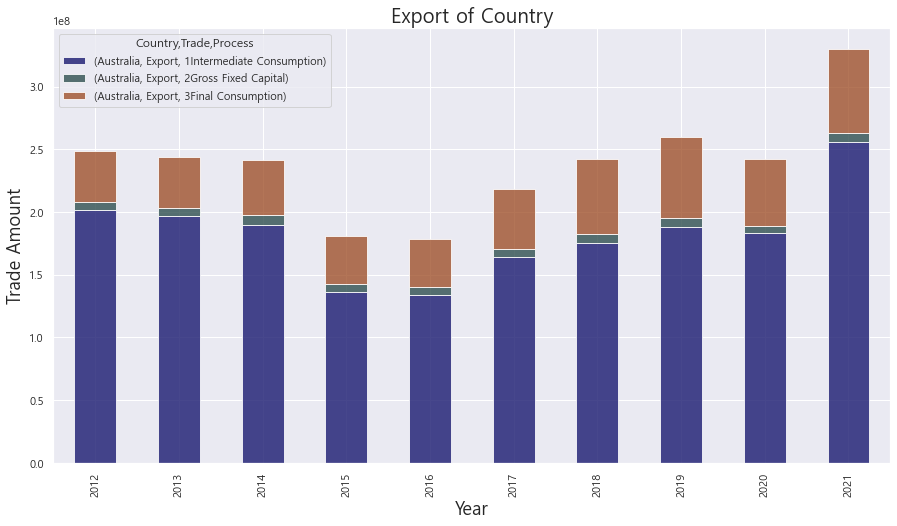

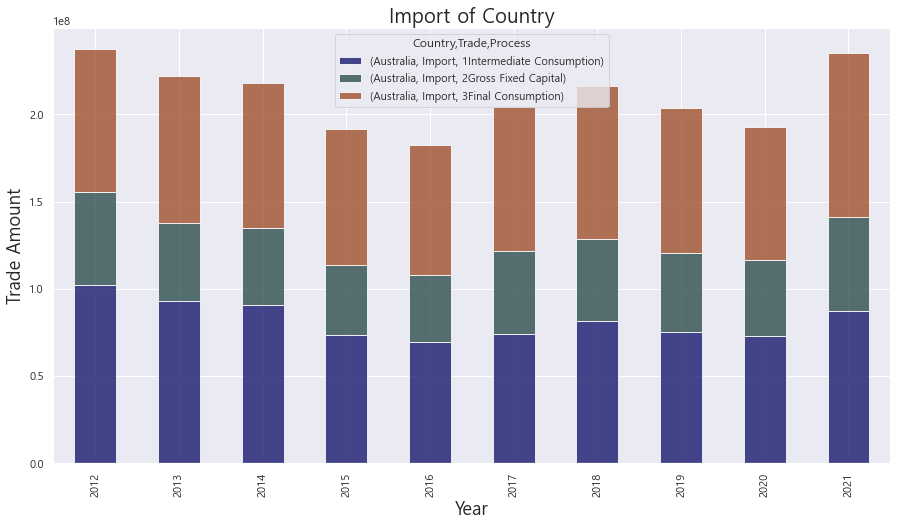

In [37]:
colors=['midnightblue', 'darkslategrey', 'sienna']

for i in range(24):
    df_prc.transpose().iloc[:, 3*i:3+3*i].plot(kind='bar', figsize=(15,8), color=colors, alpha=0.8, stacked=True)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Trade Amount', fontsize=18)
    if (3+3*i)%6 == 0 :
        plt.title('Import of Country', fontsize=20, pad=5)
        break
    else :
        plt.title('Export of Country', fontsize=20, pad=5)

# ===============================================
# Step 4 - 국가별 주요 수출입품목

In [24]:
df3 = df2.copy()

In [25]:
df4= df3.set_index(['Country','Trade','Code', 'Category','Product label']).iloc[:,:-2]
df4

2012  \
Country   Trade  Code   Category  Product label                                                   
Australia Export 100199 Category1 Wheat and meslin (excluding seed for sowing, an...  6711806.0   
                 020230 Category1 Frozen, boneless meat of bovine animals             2828207.0   
                 020130 Category1 Fresh or chilled bovine meat, boneless              1921467.0   
                 120510 Category1 Low erucic acid rape or colza seeds ""yielding ...  1527093.0   
                 100390 Category1 Barley (excluding seed for sowing)                  1358431.0   
...                                                                                         ...   
Viet_Nam  Import 401036 Category8 Endless synchronous belts, of vulcanised rubber...      330.0   
                 901540 Category8 Photogrammetrical surveying instruments and app...       74.0   
                 360500 Category8 Matches (excluding pyrotechnic articles of head...        1.0   
                 401033 Category8 Endless transmission belts of trapezoidal cross...     3153.0   
                 360690 Category8 Ferro-cerium and other pyrophoric alloys in all...     1631.0   

                                                                                           2013  \
Country   Trade  Code   Category  Product label                                                   
Australia Export 100199 Category1 Wheat and meslin (excluding seed for sowing, an...  5832548.0   
                 020230 Category1 Frozen, boneless meat of bovine animals             3370846.0   
                 020130 Category1 Fresh or chilled bovine meat, boneless              1891428.0   
                 120510 Category1 Low erucic acid rape or colza seeds ""yielding ...  2196830.0   
                 100390 Category1 Barley (excluding seed for sowing)                  1484784.0   
...                                                                                         ...   
Viet_Nam  Import 401036 Category8 Endless synchronous belts, of vulcanised rubber...      237.0   
                 901540 Category8 Photogrammetrical surveying instruments and app...      164.0   
                 360500 Category8 Matches (excluding pyrotechnic articles of head...        5.0   
                 401033 Category8 Endless transmission belts of trapezoidal cross...      572.0   
                 360690 Category8 Ferro-cerium and other pyrophoric alloys in all...      420.0   

                                                                                           2014  \
Country   Trade  Code   Category  Product label                                                   
Australia Export 100199 Category1 Wheat and meslin (excluding seed for sowing, an...  5270968.0   
                 020230 Category1 Frozen, boneless meat of bovine animals             4371609.0   
                 020130 Category1 Fresh or chilled bovine meat, boneless              2273194.0   
                 120510 Category1 Low erucic acid rape or colza seeds ""yielding ...  1285502.0   
                 100390 Category1 Barley (excluding seed for sowing)                  1597948.0   
...                                                                                         ...   
Viet_Nam  Import 401036 Category8 Endless synchronous belts, of vulcanised rubber...      269.0   
                 901540 Category8 Photogrammetrical surveying instruments and app...      305.0   
                 360500 Category8 Matches (excluding pyrotechnic articles of head...        3.0   
                 401033 Category8 Endless transmission belts of trapezoidal cross...      284.0   
                 360690 Category8 Ferro-cerium and other pyrophoric alloys in all...      463.0   

                                                                                           2015  \
Country   Trade  Code   Category  Product label                                                   
Australia Export 100199 Categ

## 국가 - 카테고리별 주요 수출입품목 (최댓값)

In [26]:
df3_tmp = df3.groupby(['Country', 'Category']).max().iloc[:,1:12]
del df3_tmp['Product label']

In [27]:
max_list=[]
for cols in df3_tmp :
    for vals in df3_tmp[cols] :
        max_list.append(df4.index[df4[cols]==vals][0])

max_cat = pd.DataFrame(max_list, columns=['국가', '수출입유형', 'HS품목코드','카테고리', '품목설명']).set_index(['국가','카테고리'])  

m = max_cat.reset_index()

In [28]:
max_cat.iloc[864:960,:].head(60)

수출입유형  HS품목코드  \
국가           카테고리                        
Australia    Category1  Export  100199   
             Category2  Export  260111   
             Category3  Export  740311   
             Category4  Export  710813   
             Category5  Import  870323   
             Category6  Import  847130   
             Category7  Import  300490   
             Category8  Import  890610   
China        Category1  Import  120190   
             Category2  Import  270900   
             Category3  Import  740311   
             Category4  Export  640299   
             Category5  Import  870323   
             Category6  Import  854231   
             Category7  Export  950300   
             Category8  Import  490700   
Germany      Category1  Export  210690   
             Category2  Import  271121   
             Category3  Export  853710   
             Category4  Import  710812   
             Category5  Export  870323   
             Category6  Import  847130   
             Category7  Export  300490   
             Category8  Export  401039   
India        Category1  Export  100630   
             Category2  Import  270900   
             Category3  Export  760110   
             Category4  Import  710812   
             Category5  Export  870899   
             Category6  Import  854231   
             Category7  Export  300490   
             Category8  Import  901580   
Japan        Category1  Import  100590   
             Category2  Import  270900   
             Category3  Export  853224   
             Category4  Export  710812   
             Category5  Export  870323   
             Category6  Export  848620   
             Category7  Import  300490   
             Category8  Import  901580   
Korea        Category1  Import  100590   
             Category2  Import  270900   
             Category3  Export  853400   
             Category4  Export  710691   
             Category5  Export  870323   
             Category6  Export  854232   
             Category7  Export  330499   
             Category8  Export  930690   
Russia       Category1  Export  100199   
             Category2  Export  270900   
             Category3  Export  760110   
             Category4  Export  710812   
             Category5  Export  720712   
             Category6  Import  851712   
             Category7  Import  300490   
             Category8  Export  490700   
Saudi_Arabia Category1  Export  310210   
             Category2  Export  390210   
             Category3  Import  740811   
             Category4  Import  710812   

                                                                     품목설명  
국가           카테고리                                                          
Australia    Category1  Wheat and meslin (excluding seed for sowing, a...  
             Category2  Non-agglomerated iron ores and concentrates (e...  
             Category3  Copper, refined, in the form of cathodes and s...  
             Category4  Gold, incl. gold plated with platinum, in semi...  
             Category5  Motor cars and other motor vehicles principall...  
             Category6  Data-processing machines, automatic, portable,...  
             Category7  Medicaments consisting of mixed or unmixed pro...  
             Category8                              Warships of all kinds  
China        Category1  Soya beans, whether or not broken (excluding s...  
             Category2  Petroleum oils and oils obtained from bitumino...  
             Category3  Copper, refined, in the form of cathodes and s...  
             Category4  Footwear with outer soles and uppers of rubber...  
             Category5  Motor cars and other motor vehicles principall...  
             Category6  Electronic integrated circuits as processors a...  
             Category7  Tricycles, scooters, pedal cars and similar wh...  
             Category8  Unused postage, revenue or similar stamps of c...  
Germany      Category1                          Food

## 한국의 10대 수출품목

In [29]:
## 한국 전체 최대 수출입품목 (15개?)
kor = df3[(df3['Country']=='Korea') & (df3['Trade']=='Export')].set_index(['Code', 'Product label'])
k17 = kor['2017'].sort_values(ascending=False).head(15)
k18 = kor['2018'].sort_values(ascending=False).head(15)
k19 = kor['2019'].sort_values(ascending=False).head(15)
k20 = kor['2020'].sort_values(ascending=False).head(15)
k21 = kor['2021'].sort_values(ascending=False).head(15)

### <한국의 주요 수출 품목별 중국 수입 시장 점유율 추이(2017~2021)>

In [30]:
top10_k = pd.concat([k17, k18, k19, k20, k21], axis=1).dropna()
top10_k

,,2017,2018,2019,2020,2021
Code,Product label,,,,,
854232,Electronic integrated circuits as memories,60506974.0,83048246.0,53163163.0,52359154.0,69177215.0
271019,"Medium oils and preparations, of petroleum or bituminous minerals, not containing biodiesel, ...",25256941.0,34171305.0,29751793.0,17844010.0,26178125.0
854231,"Electronic integrated circuits as processors and controllers, whether or not combined with ...",21362697.0,22100868.0,20681846.0,23516687.0,30406085.0
870323,"Motor cars and other motor vehicles principally designed for the transport of persons, incl. ...",19133730.0,19612091.0,19701460.0,15352522.0,16416185.0
890120,Tankers,13148739.0,10861150.0,12384947.0,10250231.0,9618424.0
870899,"Parts and accessories, for tractors, motor vehicles for the transport of ten or more persons, ...",8788530.0,8570782.0,8681574.0,7312171.0,8714846.0
271012,"Light oils and preparations, of petroleum or bituminous minerals which >= 90% by volume """"incl. ...""",8198633.0,10740635.0,9477784.0,5321034.0,10841241.0
852990,"Parts suitable for use solely or principally with flat panel display modules, transmission ...",7995178.0,7240102.0,10045151.0,7799818.0,7842054.0
847330,Parts and accessories of automatic data-processing machines or for other machines of heading ...,7481776.0,12046739.0,11307539.0,13210367.0,15075179.0


* 5년(2017~2021년) 연속 한국의 대중국 수출 15위권 내 든 품목 10개

1. 854232 메모리반도체
2. 854231 비메모리반도체
3. 870323 자동차 및 운송장치
4. 890120 탱커
5. 271019 파라핀계 미네랄 오일
6. 870899 기타 자동차 부분품과 부속품
7. 852990 무선송수신기기 
8. 847330 자동 데이터 처리기기 부품 
9. 851770 무선통신기기 부품 

## 중국 수입 top10 품목
### 겹치는 항목
- 854231 비메모리반도체
- 854232 메모리반도체
- 851770 무선통신기기 부품
- 870323 자동차 및 운송장치

In [31]:
chn = df3[(df3['Country']=='China') & (df3['Trade']=='Import')].set_index(['Country', 'Code', 'Product label'])
chn = chn.iloc[:, :-4]

In [32]:
c17 = chn['2017'].sort_values(ascending=False).head(15)
c18 = chn['2018'].sort_values(ascending=False).head(15)
c19 = chn['2019'].sort_values(ascending=False).head(15)
c20 = chn['2020'].sort_values(ascending=False).head(15)
c21 = chn['2021'].sort_values(ascending=False).head(15)

In [33]:
top10_c =  pd.concat([c17, c18, c19, c20, c21], axis=1).dropna()
top10_c.head(10)

2017  \
Country Code   Product label                                                     
China   270900 Petroleum oils and oils obtained from bituminou...  162191057.0   
        854231 Electronic integrated circuits as processors an...  111363038.0   
        854232 Electronic integrated circuits as memories           88270996.0   
        260111 Non-agglomerated iron ores and concentrates (ex...   74278723.0   
        854239 Electronic integrated circuits (excluding such ...   48614337.0   
        851770 Parts of telephone sets, telephones for cellula...   41295399.0   
        120190 Soya beans, whether or not broken (excluding se...   39627273.0   
        870323 Motor cars and other motor vehicles principally...   37905123.0   
        901380 Liquid crystal devices, n.e.s. and other optica...   30541144.0   
        260300 Copper ores and concentrates                         26107243.0   

                                                                          2018  \
Country Code   Product label                                                     
China   270900 Petroleum oils and oils obtained from bituminou...  239222367.0   
        854231 Electronic integrated circuits as processors an...  127430722.0   
        854232 Electronic integrated circuits as memories          122972378.0   
        260111 Non-agglomerated iron ores and concentrates (ex...   72674453.0   
        854239 Electronic integrated circuits (excluding such ...   51691958.0   
        851770 Parts of telephone sets, telephones for cellula...   42389087.0   
        120190 Soya beans, whether or not broken (excluding se...   38077974.0   
        870323 Motor cars and other motor vehicles principally...   36840853.0   
        901380 Liquid crystal devices, n.e.s. and other optica...   26248601.0   
        260300 Copper ores and concentrates                         32727689.0   

                                                                          2019  \
Country Code   Product label                                                     
China   270900 Petroleum oils and oils obtained from bituminou...  238707061.0   
        854231 Electronic integrated circuits as processors an...  143495001.0   
        854232 Electronic integrated circuits as memories           94612915.0   
        260111 Non-agglomerated iron ores and concentrates (ex...   95884545.0   
        854239 Electronic integrated circuits (excluding such ...   57225210.0   
        851770 Parts of telephone sets, telephones for cellula...   35434224.0   
        120190 Soya beans, whether or not broken (excluding se...   35419584.0   
        870323 Motor cars and other motor vehicles principally...   31983334.0   
        901380 Liquid crystal devices, n.e.s. and other optica...   20978386.0   
        260300 Copper ores and concentrates                         34080603.0   

                                                                          2020  \
Country Code   Product label                                                     
China   270900 Petroleum oils and oils obtained from bituminou...  176321269.0   
        854231 Electronic integrated circuits as processors an...  171425845.0   
        854232 Electronic integrated circuits as memories           95269863.0   
        260111 Non-agglomerated iron ores and concentrates (ex...  113324502.0   
        854239 Electronic integrated circuits (excluding such ...   70996931.0   
        851770 Parts of telephone sets, telephones for cellula...   35722443.0   
        120190 Soya beans, whether or not broken (excluding se...   39527998.0   
        870323 Motor cars and other motor vehicles principally...   33023500.0   
        901380 Liquid crystal devices, n.e.s. and other optica...   19269861.0   
        260300 Copper ores and concentrates                         34297835.0   

                                                                          2021  
Country Code   Product label                         

In [34]:
lst=[]
for i in top10_c.index :
    lst.append(i[1])

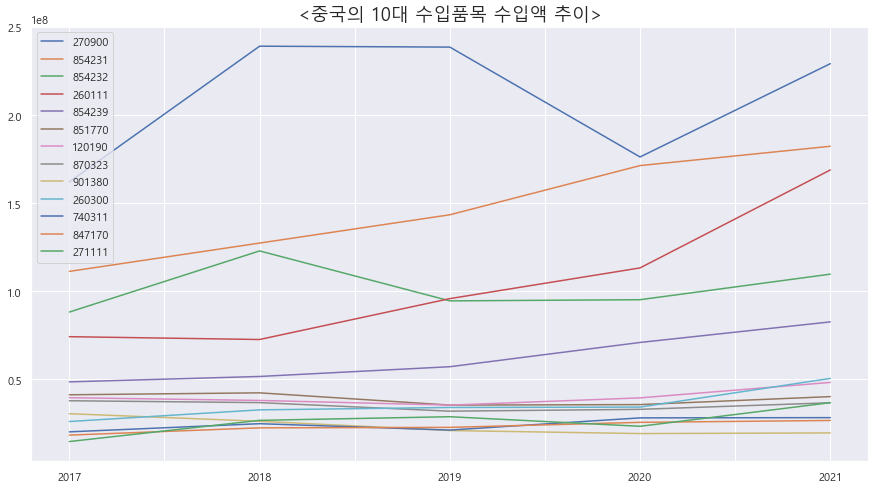

In [35]:
plt.rcParams['font.family'] = 'Malgun Gothic'
top10_c.transpose().plot(figsize=(15,8))
plt.title('<중국의 10대 수입품목 수입액 추이>', fontsize=18)
plt.legend(lst);

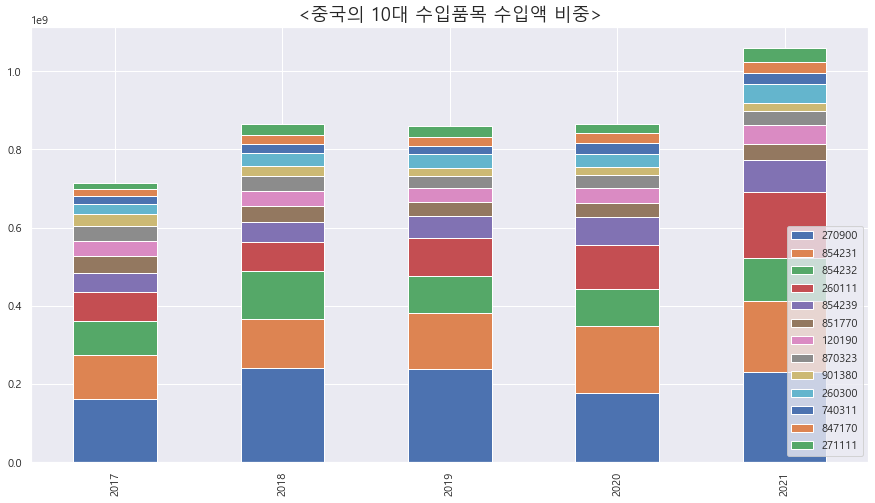

In [36]:
top10_c.T.plot(kind='bar', stacked=True, figsize=(15,8))
plt.title('<중국의 10대 수입품목 수입액 비중>', fontsize=18)
plt.legend(lst);